# 05 mlflow tracking - TODO

## Purpose
To be filled during project development

## Steps
1. 
2. 
3. 

In [15]:
# CELL 1: Imports (PEP 8 style - all imports at top)
import os
import sys
import json
import pickle
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Suppress warnings
warnings.filterwarnings('ignore')

print("🤖 Traditional ML Models for EUR/USD Prediction")
print("=" * 50)


🤖 Traditional ML Models for EUR/USD Prediction


In [16]:

# CELL 2: Setup paths
print("\n📁 Setting up project paths...")

# Get project root (one level up from notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

# Define common paths
DATA_PROCESSED = os.path.join(project_root, 'data', 'processed')
FIGURES = os.path.join(project_root, 'figures')
MODELS = os.path.join(project_root, 'models')

# Create directories if they don't exist
for directory in [FIGURES, MODELS]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

print(f"Project root: {project_root}")
print(f"Data processed: {DATA_PROCESSED}")




📁 Setting up project paths...
Project root: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone
Data processed: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed


In [17]:
# CELL 3: Load ML features (LBYL pattern - check file exists and has data)
print("\n📂 Loading ML features...")
ml_features_path = os.path.join(DATA_PROCESSED, 'ml_features.csv')

if not os.path.exists(ml_features_path):
    print(f"❌ ERROR: File not found: {ml_features_path}")
    print("Please run 03_feature_engineering.ipynb first!")
    # Exit gracefully if data not found
    raise FileNotFoundError(f"Required file not found: {ml_features_path}")

# Load the data
df = pd.read_csv(ml_features_path, index_col=0, parse_dates=True)

# Check if DataFrame is empty
if df.empty:
    print("❌ ERROR: DataFrame is EMPTY!")
    print(f"File: {ml_features_path}")
    print("Possible causes:")
    print("1. File was created but no data was written")
    print("2. All rows were dropped during processing")
    print("3. Previous notebook had an error")
    print("\n⚠️ ACTION REQUIRED:")
    print("Go back to notebook 3 and check:")
    print("1. Did the feature engineering complete?")
    print("2. Check the output of cell that saves ml_features.csv")
    print("3. Check if df_ml variable exists and has data")
    raise ValueError("DataFrame is empty - cannot proceed")
    
print(f"✅ Loaded {len(df)} rows with {len(df.columns)} columns")

# Check if index has values before accessing
if len(df.index) > 0:
    print(f"📅 Date range: {df.index[0].date()} to {df.index[-1].date()}")
else:
    print("⚠️ WARNING: DataFrame has no date index (empty index)")


📂 Loading ML features...
✅ Loaded 777 rows with 41 columns
📅 Date range: 2022-12-13 to 2025-12-08


In [18]:
# CELL 4: Prepare data for traditional ML
print("\n⚙️ Preparing data for ML models...")

# Separate features and target
if 'target' not in df.columns:
    print("❌ ERROR: 'target' column not found in data")
    raise KeyError("Target column 'target' not found in dataset")

X = df.drop('target', axis=1)
y = df['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Time-based train/test split
split_idx = int(len(X) * 0.8)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"\nTrain set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set:  {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"Train dates: {X_train.index[0].date()} to {X_train.index[-1].date()}")
print(f"Test dates:  {X_test.index[0].date()} to {X_test.index[-1].date()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled (StandardScaler)")



⚙️ Preparing data for ML models...
Features shape: (777, 40)
Target shape: (777,)

Train set: 621 samples (79.9%)
Test set:  156 samples (20.1%)
Train dates: 2022-12-13 to 2025-05-02
Test dates:  2025-05-05 to 2025-12-08
✅ Features scaled (StandardScaler)


In [19]:
# CELL 5: Load LSTM metrics for comparison (LBYL pattern)
print("\n📊 Loading LSTM results for comparison...")
lstm_metrics_path = os.path.join(MODELS, 'lstm_metrics.json')

lstm_mae = None
lstm_metrics = {}

if os.path.exists(lstm_metrics_path):
    with open(lstm_metrics_path, 'r') as f:
        lstm_metrics = json.load(f)
    
    if 'mae' in lstm_metrics:
        lstm_mae = lstm_metrics['mae']
        print(f"LSTM MAE: ${lstm_mae:.4f}")
    else:
        print("⚠️ 'mae' key not found in LSTM metrics")
else:
    print("ℹ️ LSTM metrics not found (run LSTM notebook first for comparison)")



📊 Loading LSTM results for comparison...
LSTM MAE: $107369.6274


In [20]:
# CELL 6: Train Random Forest
print("\n🌲 Training Random Forest model...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE:  ${rf_mae:.4f}")
print(f"Random Forest RMSE: ${rf_rmse:.4f}")
print(f"Random Forest R²:   {rf_r2:.4f}")



🌲 Training Random Forest model...
Random Forest MAE:  $0.0301
Random Forest RMSE: $0.0330
Random Forest R²:   -3.5592


In [21]:
# CELL 7: Train Linear Regression
print("\n📈 Training Linear Regression model...")

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MAE:  ${lr_mae:.4f}")
print(f"Linear Regression RMSE: ${lr_rmse:.4f}")
print(f"Linear Regression R²:   {lr_r2:.4f}")



📈 Training Linear Regression model...
Linear Regression MAE:  $0.0024
Linear Regression RMSE: $0.0033
Linear Regression R²:   0.9550


In [22]:
# CELL 8: Train Gradient Boosting
print("\n🚀 Training Gradient Boosting model...")

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
gb_r2 = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting MAE:  ${gb_mae:.4f}")
print(f"Gradient Boosting RMSE: ${gb_rmse:.4f}")
print(f"Gradient Boosting R²:   {gb_r2:.4f}")



🚀 Training Gradient Boosting model...
Gradient Boosting MAE:  $0.0330
Gradient Boosting RMSE: $0.0360
Gradient Boosting R²:   -4.4469


In [23]:
# CELL 9: Baseline model (LBYL pattern - check if lag_1 exists)
print("\n📊 Creating baseline model...")

baseline_mae = None
baseline_rmse = None

if 'lag_1' in X_test.columns:
    baseline_pred = X_test['lag_1']  # Yesterday's price
    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
    
    print(f"Baseline (yesterday's price) MAE:  ${baseline_mae:.4f}")
    print(f"Baseline (yesterday's price) RMSE: ${baseline_rmse:.4f}")
else:
    print("⚠️ 'lag_1' column not found for baseline model")
    print("Using simple persistence model as baseline...")
    
    # Simple persistence: use last training value
    baseline_pred = np.full_like(y_test, y_train.iloc[-1])
    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
    
    print(f"Baseline (persistence) MAE:  ${baseline_mae:.4f}")
    print(f"Baseline (persistence) RMSE: ${baseline_rmse:.4f}")



📊 Creating baseline model...
Baseline (yesterday's price) MAE:  $0.0053
Baseline (yesterday's price) RMSE: $0.0067


In [24]:
# CELL 10: Model comparison
print("\n🏆 Model Comparison")
print("=" * 50)

# Create comparison dataframe
models_comparison = pd.DataFrame({
    'Model': ['Baseline', 'Linear Regression', 'Gradient Boosting', 'Random Forest'],
    'MAE': [baseline_mae, lr_mae, gb_mae, rf_mae],
    'RMSE': [baseline_rmse, lr_rmse, gb_rmse, rf_rmse],
    'R²': [np.nan, lr_r2, gb_r2, rf_r2]
})

# Add LSTM if available
if lstm_mae is not None:
    lstm_row = pd.DataFrame({
        'Model': ['LSTM (from Notebook 4)'],
        'MAE': [lstm_mae],
        'RMSE': [lstm_metrics.get('rmse', np.nan)],
        'R²': [lstm_metrics.get('r2', np.nan)]
    })
    models_comparison = pd.concat([models_comparison, lstm_row], ignore_index=True)

print("\nModel Performance Summary:")
print(models_comparison.to_string(index=False))

# Calculate improvement over baseline
print("\n📈 Improvement over baseline (lower MAE is better):")
for idx, row in models_comparison.iterrows():
    if row['Model'] != 'Baseline' and pd.notna(row['MAE']) and pd.notna(baseline_mae):
        improvement = (baseline_mae - row['MAE']) / baseline_mae * 100
        print(f"{row['Model']:25}: {improvement:5.1f}% improvement")



🏆 Model Comparison

Model Performance Summary:
                 Model           MAE          RMSE            R²
              Baseline      0.005302      0.006704           NaN
     Linear Regression      0.002360      0.003276  9.549644e-01
     Gradient Boosting      0.033008      0.036023 -4.446936e+00
         Random Forest      0.030080      0.032957 -3.559161e+00
LSTM (from Notebook 4) 107369.627375 164856.204061 -1.954907e+14

📈 Improvement over baseline (lower MAE is better):
Linear Regression        :  55.5% improvement
Gradient Boosting        : -522.5% improvement
Random Forest            : -467.3% improvement
LSTM (from Notebook 4)   : -2025052160.8% improvement



🎯 Feature Importance Analysis (Random Forest)

Top 15 Most Important Features:
  high                     : 0.5506
  low                      : 0.4223
  std_50                   : 0.0042
  open                     : 0.0031
  close                    : 0.0028
  volatility_20d           : 0.0011
  day_of_month             : 0.0011
  return_5d                : 0.0010
  volatility_5d            : 0.0009
  macd_signal              : 0.0009
  std_5                    : 0.0008
  month                    : 0.0007
  std_20                   : 0.0006
  lag_2                    : 0.0006
  lag_3                    : 0.0006


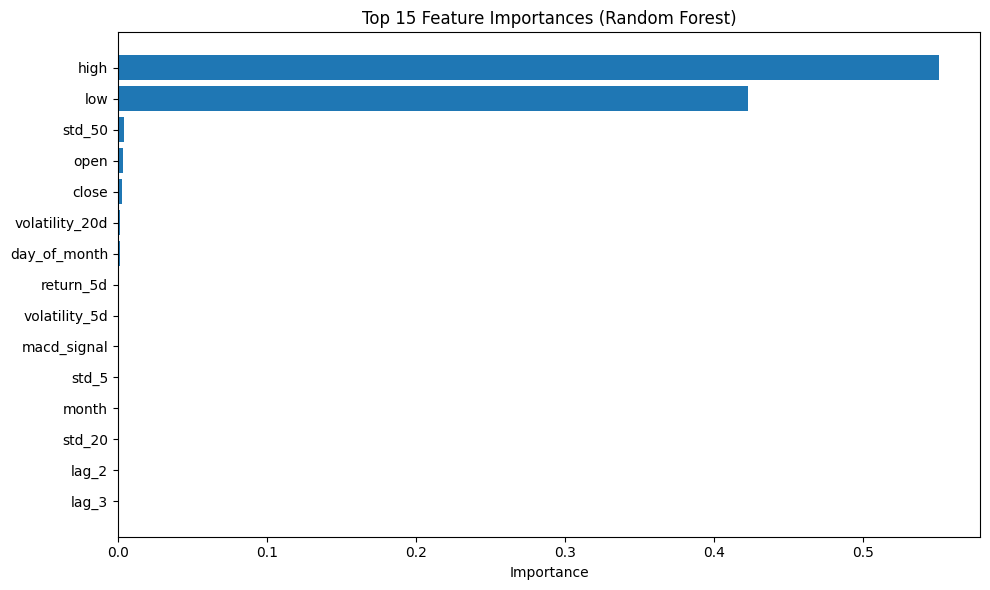


✅ Feature importance plot saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/figures/ml_feature_importance.png


In [25]:
# CELL 11: Feature importance analysis
print("\n🎯 Feature Importance Analysis (Random Forest)")

if hasattr(rf_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(15)
    
    print("\nTop 15 Most Important Features:")
    for idx, row in feature_importance.iterrows():
        print(f"  {row['Feature']:25}: {row['Importance']:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Top 15 Feature Importances (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    feature_importance_path = os.path.join(FIGURES, 'ml_feature_importance.png')
    plt.savefig(feature_importance_path, dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Feature importance plot saved to: {feature_importance_path}")
else:
    print("⚠️ Feature importance not available for Random Forest model")



📊 Visualizing model predictions...


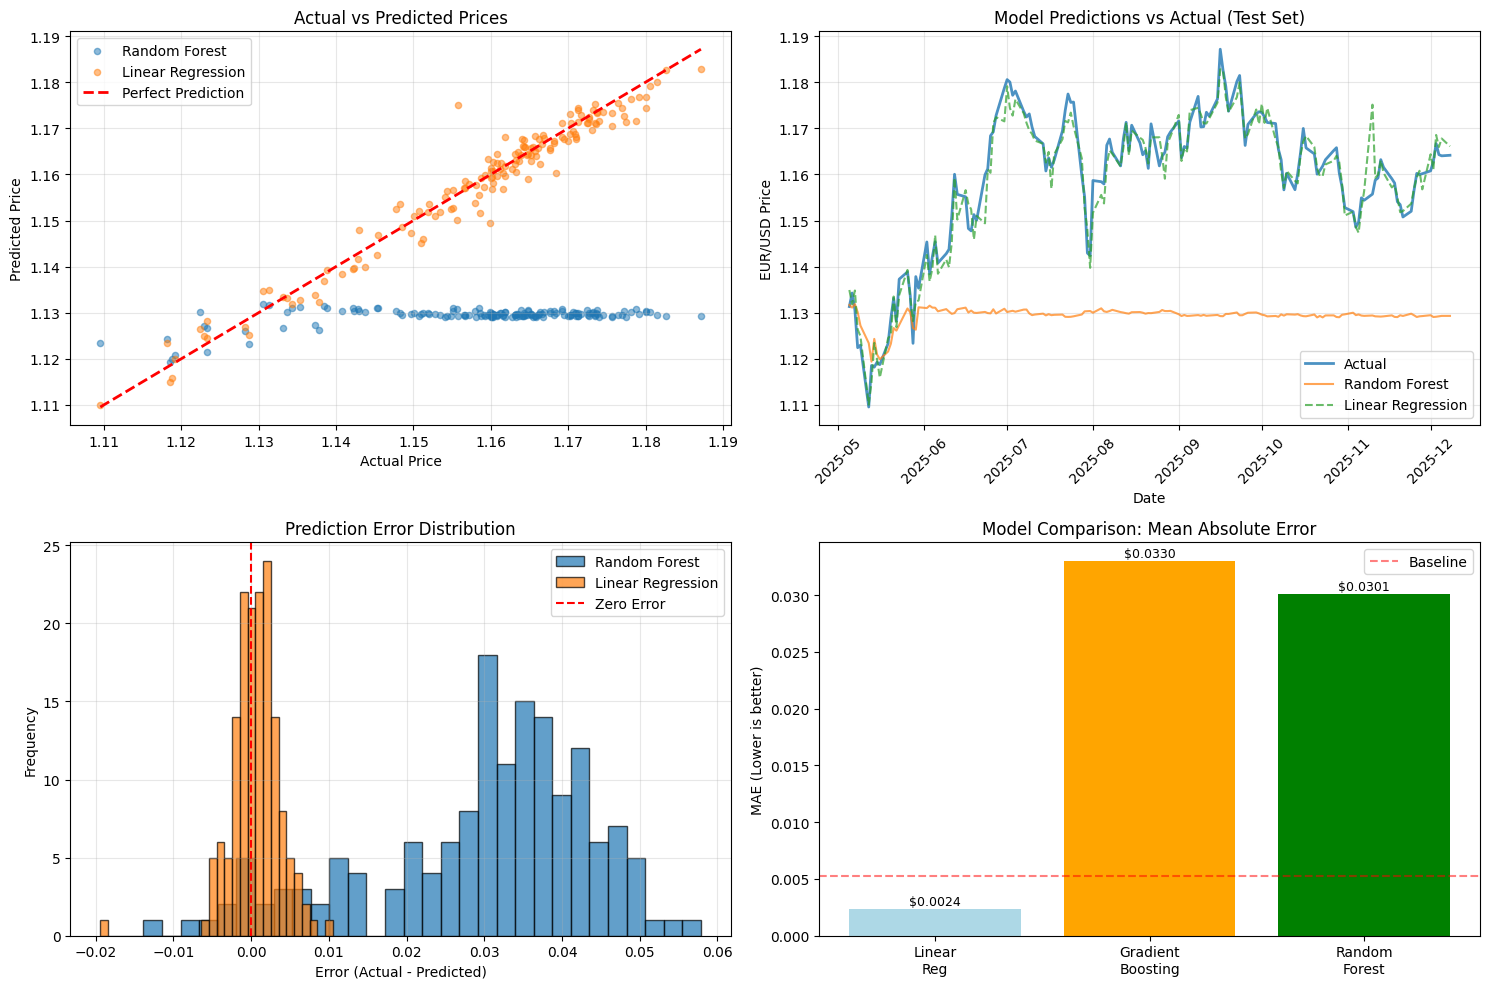

✅ Model comparison plot saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/figures/ml_model_comparison.png


In [26]:
# CELL 12: Visualize predictions
print("\n📊 Visualizing model predictions...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Actual vs Predicted comparison
axes[0, 0].scatter(y_test, y_pred_rf, alpha=0.5, s=20, label='Random Forest')
axes[0, 0].scatter(y_test, y_pred_lr, alpha=0.5, s=20, label='Linear Regression')
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_title('Actual vs Predicted Prices')
axes[0, 0].set_xlabel('Actual Price')
axes[0, 0].set_ylabel('Predicted Price')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Time series comparison
test_dates = X_test.index
axes[0, 1].plot(test_dates, y_test, label='Actual', alpha=0.8, linewidth=2)
axes[0, 1].plot(test_dates, y_pred_rf, label='Random Forest', alpha=0.7)
axes[0, 1].plot(test_dates, y_pred_lr, label='Linear Regression', alpha=0.7, linestyle='--')
axes[0, 1].set_title('Model Predictions vs Actual (Test Set)')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('EUR/USD Price')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45)

# Plot 3: Error distribution comparison
rf_errors = y_test - y_pred_rf
lr_errors = y_test - y_pred_lr

axes[1, 0].hist(rf_errors, bins=30, alpha=0.7, label='Random Forest', edgecolor='black')
axes[1, 0].hist(lr_errors, bins=30, alpha=0.7, label='Linear Regression', edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--', label='Zero Error')
axes[1, 0].set_title('Prediction Error Distribution')
axes[1, 0].set_xlabel('Error (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Model comparison bar chart
models_for_chart = ['Linear\nReg', 'Gradient\nBoosting', 'Random\nForest']
mae_values = [lr_mae, gb_mae, rf_mae]
colors = ['lightblue', 'orange', 'green']

bars = axes[1, 1].bar(models_for_chart, mae_values, color=colors)
axes[1, 1].axhline(y=baseline_mae, color='r', linestyle='--', alpha=0.5, label='Baseline')
axes[1, 1].set_ylabel('MAE (Lower is better)')
axes[1, 1].set_title('Model Comparison: Mean Absolute Error')
axes[1, 1].legend()

# Add value labels on bars
for bar, value in zip(bars, mae_values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
                   f'${value:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
ml_comparison_path = os.path.join(FIGURES, 'ml_model_comparison.png')
plt.savefig(ml_comparison_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"✅ Model comparison plot saved to: {ml_comparison_path}")


In [27]:
# CELL 13: Select and save best model
print("\n💾 Selecting and saving best model...")

# Determine best model based on MAE
model_performance = {
    'Random Forest': {'model': rf_model, 'mae': rf_mae, 'predictions': y_pred_rf},
    'Gradient Boosting': {'model': gb_model, 'mae': gb_mae, 'predictions': y_pred_gb},
    'Linear Regression': {'model': lr_model, 'mae': lr_mae, 'predictions': y_pred_lr}
}

# Find best model (lowest MAE)
best_model_name = min(model_performance.keys(), 
                      key=lambda x: model_performance[x]['mae'])
best_model_info = model_performance[best_model_name]

print(f"🏆 Best model: {best_model_name} (MAE: ${best_model_info['mae']:.4f})")

# Save the best model
best_model_path = os.path.join(MODELS, f'best_ml_model_{best_model_name.lower().replace(" ", "_")}.joblib')
joblib.dump(best_model_info['model'], best_model_path)
print(f"✅ Best model saved to: {best_model_path}")

# Save the scaler
scaler_path = os.path.join(MODELS, 'ml_scaler.joblib')
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to: {scaler_path}")



💾 Selecting and saving best model...
🏆 Best model: Linear Regression (MAE: $0.0024)
✅ Best model saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/models/best_ml_model_linear_regression.joblib
✅ Scaler saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/models/ml_scaler.joblib


In [28]:
# CELL 14: Save model metrics and predictions
print("\n📊 Saving model metrics and predictions...")

# Save all predictions
all_predictions = pd.DataFrame({
    'date': X_test.index,
    'actual': y_test.values,
    'rf_predicted': y_pred_rf,
    'lr_predicted': y_pred_lr,
    'gb_predicted': y_pred_gb,
    'baseline': baseline_pred.values if hasattr(baseline_pred, 'values') else baseline_pred
})

predictions_path = os.path.join(DATA_PROCESSED, 'ml_predictions.csv')
all_predictions.to_csv(predictions_path, index=False)
print(f"✅ All predictions saved to: {predictions_path}")

# Save comprehensive metrics
metrics = {
    'best_model': best_model_name,
    'best_mae': float(best_model_info['mae']),
    'baseline_mae': float(baseline_mae),
    'improvement_pct': float((baseline_mae - best_model_info['mae']) / baseline_mae * 100),
    'all_models': {
        'Random Forest': {
            'mae': float(rf_mae),
            'rmse': float(rf_rmse),
            'r2': float(rf_r2)
        },
        'Linear Regression': {
            'mae': float(lr_mae),
            'rmse': float(lr_rmse),
            'r2': float(lr_r2)
        },
        'Gradient Boosting': {
            'mae': float(gb_mae),
            'rmse': float(gb_rmse),
            'r2': float(gb_r2)
        }
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_period': {
        'start': X_test.index[0].strftime('%Y-%m-%d'),
        'end': X_test.index[-1].strftime('%Y-%m-%d'),
        'samples': len(X_test)
    }
}

# Add LSTM comparison if available
if lstm_mae is not None:
    metrics['lstm_comparison'] = {
        'lstm_mae': float(lstm_mae),
        'best_ml_vs_lstm': float(best_model_info['mae'] - lstm_mae)
    }

metrics_path = os.path.join(MODELS, 'ml_models_metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"✅ Model metrics saved to: {metrics_path}")



📊 Saving model metrics and predictions...
✅ All predictions saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed/ml_predictions.csv
✅ Model metrics saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/models/ml_models_metrics.json


In [29]:

# CELL 15: Make sample prediction
print("\n🔮 Making sample prediction with best model...")

# Get the latest data point
latest_features = X_test_scaled[-1:].reshape(1, -1)

# Make prediction
sample_prediction = best_model_info['model'].predict(latest_features)[0]
actual_value = y_test.iloc[-1]

print(f"Sample prediction (latest test data):")
print(f"  Actual price:     ${actual_value:.4f}")
print(f"  Predicted price:  ${sample_prediction:.4f}")
print(f"  Error:            ${abs(actual_value - sample_prediction):.4f}")



🔮 Making sample prediction with best model...
Sample prediction (latest test data):
  Actual price:     $1.1641
  Predicted price:  $1.1661
  Error:            $0.0020


In [30]:

# CELL 16: Summary
print("\n" + "=" * 60)
print("✅ TRADITIONAL ML MODELS COMPLETE")
print("=" * 60)

print(f"\n1. MODEL PERFORMANCE:")
print(f"   • Best model: {best_model_name}")
print(f"   • Best MAE: ${best_model_info['mae']:.4f}")
print(f"   • Improvement over baseline: {metrics['improvement_pct']:.1f}%")

if lstm_mae is not None:
    comparison = best_model_info['mae'] - lstm_mae
    if comparison < 0:
        print(f"   • ML model is ${abs(comparison):.4f} BETTER than LSTM")
    else:
        print(f"   • ML model is ${comparison:.4f} WORSE than LSTM")

print(f"\n2. FILES SAVED:")
print(f"   • {best_model_path}")
print(f"   • {scaler_path}")
print(f"   • {predictions_path}")
print(f"   • {metrics_path}")
print(f"   • {feature_importance_path}")
print(f"   • {ml_comparison_path}")

print(f"\n3. NEXT STEPS:")
print("   • Open 06_mlflow_tracking.ipynb for experiment tracking")
print("   • Open 07_api_development.ipynb for API creation")

print("\n🎉 Traditional ML models ready for MLOps integration!")


✅ TRADITIONAL ML MODELS COMPLETE

1. MODEL PERFORMANCE:
   • Best model: Linear Regression
   • Best MAE: $0.0024
   • Improvement over baseline: 55.5%
   • ML model is $107369.6250 BETTER than LSTM

2. FILES SAVED:
   • /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/models/best_ml_model_linear_regression.joblib
   • /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/models/ml_scaler.joblib
   • /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed/ml_predictions.csv
   • /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/models/ml_models_metrics.json
   • /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/figures/ml_feature_importance.png
   • /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/fig